path train: '/kaggle/input/indonesian-food/dataset/train'<br>
path test: '/kaggle/input/indonesian-food/dataset/test'<br>
path valid: '/kaggle/input/indonesian-food/dataset/valid'<br>
ada 5 kelas: bakso gado gudeg rendang sate

In [1]:
# import tensorflow as tf
# from tensorflow import keras
# from PIL import Image
# import os
# import numpy as np
# # Let's check size of images
# base_dir = '/kaggle/input/indonesian-food/dataset/train/bakso'
# for image in list(os.walk("/kaggle/input/indonesian-food/dataset/train/bakso"))[0][2]:
#   a = Image.open(os.path.join(base_dir, image))
#   print(np.asarray(a).shape)

In [2]:
import tensorflow as tf

print('\\u2022 Using TensorFlow Version:', tf.__version__)

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


\u2022 Using TensorFlow Version: 2.11.0


In [3]:
!pip install Keras-Preprocessing

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.6/42.6 kB 3.4 MB/s eta 0:00:00


In [4]:
# import os

# base_dir = '/kaggle/input/indonesian-food/dataset/train'

# bakso_dir = os.path.join(base_dir, 'bakso')
# gado_dir = os.path.join(base_dir, 'gado')
# gudeg_dir = os.path.join(base_dir, 'gudeg')
# rendang_dir = os.path.join(base_dir, 'rendang')
# sate_dir = os.path.join(base_dir, 'sate')

# print('total training bakso images:', len(os.listdir(bakso_dir)))
# print('total training gado images:', len(os.listdir(gado_dir)))
# print('total training gudeg images:', len(os.listdir(gudeg_dir)))
# print('total training rendang images:', len(os.listdir(rendang_dir)))
# print('total training sate images:', len(os.listdir(sate_dir)))

# bakso_files = os.listdir(bakso_dir)
# print(bakso_files[:10])

# gado_files = os.listdir(gado_dir)
# print(gado_files[:10])

# gudeg_files = os.listdir(gudeg_dir)
# print(gudeg_files[:10])

# rendang_files = os.listdir(rendang_dir)
# print(rendang_files[:10])

# sate_files = os.listdir(sate_dir)
# print(sate_files[:10])

In [5]:
import os
import tensorflow as tf
import tensorflow.keras.layers as tflayers
from tensorflow import keras
from tensorflow.keras.applications import Xception
from tensorflow.keras.layers import Dense
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras_tuner import HyperModel, RandomSearch
from keras_tuner.engine.hyperparameters import HyperParameters

IMAGE_SIZE = 224
BATCH_SIZE = 128
# with tf.device('/gpu:0'):
model = Sequential()

# base_model = Xception(
#     input_shape = (IMAGE_SIZE, IMAGE_SIZE, 3),
#     include_top=False,
#     weights='imagenet'
# )
# model.add(base_model)
# model.add(tf.keras.layers.GlobalAveragePooling2D())

# nontransfer learning
model.add(tflayers.Conv2D(32, (3,3), activation='relu', input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3)))
model.add(tflayers.MaxPooling2D(2,2))

model.add(tflayers.Conv2D(64, (3,3), activation='relu'))
model.add(tflayers.MaxPooling2D(2,2))

model.add(tflayers.Conv2D(128, (3,3), activation='relu'))
model.add(tflayers.MaxPooling2D(2,2))
model.add(tflayers.Conv2D(256, (3,3), activation='relu'))
model.add(tflayers.MaxPooling2D(2,2))
model.add(tflayers.Conv2D(256, (3,3), activation='relu'))
model.add(tflayers.MaxPooling2D(2,2))
model.add(tflayers.Flatten())

# Tune the hyperparameters for the Dense layer
model.add(Dense(512, activation='relu'))
#     model.add(tflayers.Dropout(0.5))
model.add(Dense(4, activation='softmax'))

# initial_LR = 0.001
# optimizer = tf.keras.optimizers.Adam(learning_rate=initial_LR)
# new_learning_rate = 0.0005
# optimizer.learning_rate.assign(new_learning_rate)

model.compile(
    optimizer='adam', 
    loss=tf.keras.losses.CategoricalCrossentropy(), 
    metrics=['accuracy']
)

# Print the model summary
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 222, 222, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 111, 111, 32)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 109, 109, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 54, 54, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 52, 52, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 26, 26, 128)      0

In [6]:
TRAINING_DIR = "/kaggle/input/indonesian-food/dataset/train"
VALIDATION_DIR = "/kaggle/input/indonesian-food/dataset/test"

augmentation_parameters = {
    'rotation_range': 20,
    'width_shift_range': 0.2,
    'height_shift_range': 0.2,
    'zoom_range': 0.2,
    'horizontal_flip': True,
    'vertical_flip': True,
    'brightness_range': (0.8, 1.2),
#     'channel_shift_range': 20,
}

# with tf.device('/gpu:0'):
training_datagen = ImageDataGenerator(
    rescale=1./255,
    **augmentation_parameters
)

validation_datagen = ImageDataGenerator(rescale = 1./255)

train_generator = training_datagen.flow_from_directory(
    TRAINING_DIR,
    target_size=(IMAGE_SIZE, IMAGE_SIZE),
    class_mode='categorical',
    batch_size=BATCH_SIZE
)

validation_generator = validation_datagen.flow_from_directory(
    VALIDATION_DIR,
    target_size=(IMAGE_SIZE, IMAGE_SIZE),
    class_mode='categorical',
    batch_size=BATCH_SIZE
)



Found 7754 images belonging to 4 classes.
Found 866 images belonging to 4 classes.


In [7]:
# Perform hyperparameter tuning
# tuner.search(
#     train_generator, 
#     validation_data=validation_generator, 
#     epochs=10
# #     steps_per_epoch=100
# )

# Get the best hyperparameters and build the final model
# best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
# model = tuner.hypermodel.build(best_hps)

In [8]:
# Build the model with the optimal hyperparameters and train it on the data for 50 epochs
# model = tuner.hypermodel.build(best_hps)
# with tf.device('/gpu:0'):
# Train the model
history = model.fit(
    train_generator, 
    epochs=50, 
    verbose=1, 
    validation_data = validation_generator
)

val_acc_per_epoch = history.history['val_accuracy']
best_epoch = val_acc_per_epoch.index(max(val_acc_per_epoch)) + 1
print('Best epoch: %d' % (best_epoch,))

Epoch 1/50
61/61 [==============================] - 173s 3s/step - loss: 1.1055 - accuracy: 0.4928 - val_loss: 1.0383 - val_accuracy: 0.4954
Epoch 2/50
61/61 [==============================] - 113s 2s/step - loss: 0.9209 - accuracy: 0.5948 - val_loss: 0.8597 - val_accuracy: 0.6374
Epoch 3/50
61/61 [==============================] - 113s 2s/step - loss: 0.8374 - accuracy: 0.6399 - val_loss: 0.8456 - val_accuracy: 0.6293
Epoch 4/50
61/61 [==============================] - 114s 2s/step - loss: 0.7824 - accuracy: 0.6759 - val_loss: 0.7809 - val_accuracy: 0.6744
Epoch 5/50
61/61 [==============================] - 114s 2s/step - loss: 0.7622 - accuracy: 0.6806 - val_loss: 0.7268 - val_accuracy: 0.7044
Epoch 6/50
61/61 [==============================] - 114s 2s/step - loss: 0.6668 - accuracy: 0.7266 - val_loss: 0.5587 - val_accuracy: 0.7748
Epoch 7/50
61/61 [==============================] - 115s 2s/step - loss: 0.6564 - accuracy: 0.7381 - val_loss: 0.6922 - val_accuracy: 0.7125
Epoch 8/50
61

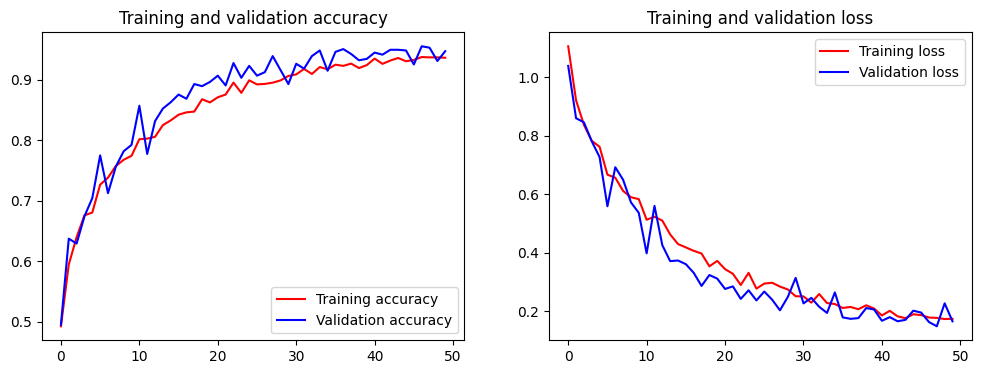

In [9]:
import matplotlib.pyplot as plt

# Plot the results
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

figure, axis = plt.subplots(1, 2, figsize=(12, 4))

axis[0].plot(epochs, acc, 'r', label='Training accuracy')
axis[0].plot(epochs, val_acc, 'b', label='Validation accuracy')
axis[0].set_title("Training and validation accuracy")
axis[0].legend(loc=0)

axis[1].plot(epochs, loss, 'r', label='Training loss')
axis[1].plot(epochs, val_loss, 'b', label='Validation loss')
axis[1].set_title("Training and validation loss")
axis[1].legend(loc=0)


plt.show()

In [10]:
save_locally = tf.saved_model.SaveOptions(experimental_io_device='/job:localhost')
checkpoints_cb = tf.keras.callbacks.ModelCheckpoint('./checkpoints', options=save_locally)

In [11]:
# hypermodel = tuner.hypermodel.build(best_hps)

# Retrain the model
historyFinal = model.fit(
    train_generator, 
    epochs=best_epoch, 
    verbose=1,
    validation_data = validation_generator,
    callbacks=[checkpoints_cb]
)

Epoch 1/47
61/61 [==============================] - 116s 2s/step - loss: 0.1583 - accuracy: 0.9411 - val_loss: 0.1626 - val_accuracy: 0.9469
Epoch 2/47
61/61 [==============================] - 115s 2s/step - loss: 0.1653 - accuracy: 0.9395 - val_loss: 0.1717 - val_accuracy: 0.9480
Epoch 3/47
61/61 [==============================] - 114s 2s/step - loss: 0.1571 - accuracy: 0.9435 - val_loss: 0.1696 - val_accuracy: 0.9515
Epoch 4/47
61/61 [==============================] - 115s 2s/step - loss: 0.1409 - accuracy: 0.9498 - val_loss: 0.1882 - val_accuracy: 0.9434
Epoch 5/47
61/61 [==============================] - 117s 2s/step - loss: 0.1571 - accuracy: 0.9439 - val_loss: 0.1541 - val_accuracy: 0.9550
Epoch 6/47
61/61 [==============================] - 115s 2s/step - loss: 0.1394 - accuracy: 0.9503 - val_loss: 0.1891 - val_accuracy: 0.9342
Epoch 7/47
61/61 [==============================] - 115s 2s/step - loss: 0.1596 - accuracy: 0.9413 - val_loss: 0.1739 - val_accuracy: 0.9446
Epoch 8/47
61

In [12]:
# eval_result = hypermodel.evaluate(img_test, label_test)
# print("[test loss, test accuracy]:", eval_result)

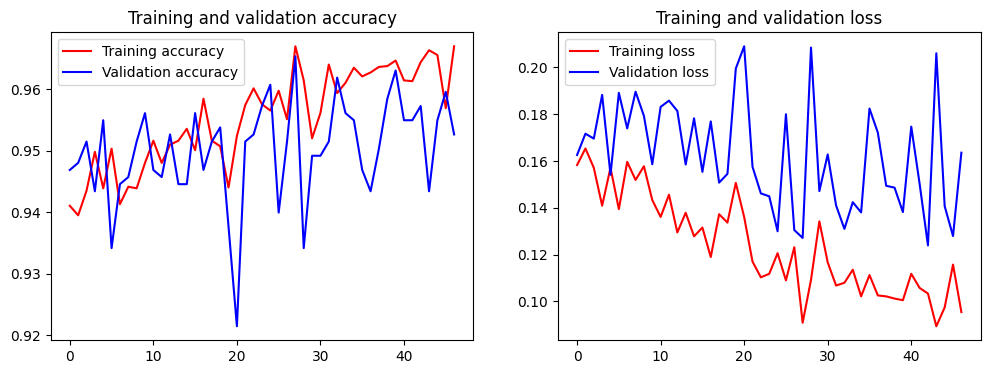

In [13]:
import matplotlib.pyplot as plt

# Plot the results
acc = historyFinal.history['accuracy']
val_acc = historyFinal.history['val_accuracy']
loss = historyFinal.history['loss']
val_loss = historyFinal.history['val_loss']

epochs = range(len(acc))

figure, axis = plt.subplots(1, 2, figsize=(12, 4))

axis[0].plot(epochs, acc, 'r', label='Training accuracy')
axis[0].plot(epochs, val_acc, 'b', label='Validation accuracy')
axis[0].set_title("Training and validation accuracy")
axis[0].legend(loc=0)

axis[1].plot(epochs, loss, 'r', label='Training loss')
axis[1].plot(epochs, val_loss, 'b', label='Validation loss')
axis[1].set_title("Training and validation loss")
axis[1].legend(loc=0)


plt.show()

In [14]:
# Define the path to the directory where the checkpoints were saved
checkpoint_dir = './checkpoints'

# Load the best checkpoint using tf.keras.models.load_model()
best_model = tf.keras.models.load_model(checkpoint_dir)

In [15]:
from datetime import datetime
# current date and time
now = datetime.now()

time_stamp = datetime.timestamp(now)
name = f'model-train-{time_stamp}'
best_model.save(f'{name}.h5')

In [16]:
# import tensorflow as tf
# loaded_model = tf.keras.models.load_model(
#     '/kaggle/input/models/model-train-1685123377.707976.h5'
# )

In [17]:
import numpy as np
import os
from tensorflow.keras.utils import load_img, img_to_array
import tensorflow as tf



class_names = list(train_generator.class_indices)
print(class_names)
 
# predicting images
TEST_DIR = '/kaggle/input/indonesian-food/dataset/val'
for dirname, _, filenames in os.walk(TEST_DIR):
    if dirname is not TEST_DIR:
        last_dir = os.path.basename(os.path.normpath(dirname))
        correct = 0
        for idx, filename in enumerate(filenames):
            path = filename

            img = load_img(os.path.join(
                os.path.join(TEST_DIR, dirname), filename), target_size=(IMAGE_SIZE, IMAGE_SIZE))
            x = img_to_array(img)
            x = np.expand_dims(x, axis=0)

            images = np.vstack([x])
            classes = best_model.predict(images, batch_size=128, verbose=0)
#             classes = loaded_model.predict(images, batch_size=128, verbose=0)
            score = tf.nn.softmax(classes[0])
            
            predicted_class = np.argmax(score)
            predicted_class_name = class_names[np.argmax(score)]

            if(last_dir==predicted_class_name): correct += 1
#             print("Image: ", filename)
#             print(
#                 "This image most likely belongs to {} with a {:.2f} percent confidence.\n"
#                 .format(predicted_class_name, 100 * np.max(score))
#             )
        
        print(f'untuk folder {last_dir}')
        print("Jumlah data",len(os.listdir(os.path.join(TEST_DIR, dirname))))
        print("Jumlah data benar", correct)
        print(
            "Akurasi {:.2f}\n"
            .format(100*(correct/len(os.listdir(os.path.join(TEST_DIR, dirname)))))
        )


['bakso', 'gado', 'rendang', 'sate']
untuk folder sate
Jumlah data 89
Jumlah data benar 75
Akurasi 84.27

untuk folder bakso
Jumlah data 90
Jumlah data benar 73
Akurasi 81.11

untuk folder rendang
Jumlah data 83
Jumlah data benar 72
Akurasi 86.75

untuk folder gado gado
Jumlah data 87
Jumlah data benar 0
Akurasi 0.00

